Epoch 1 | Loss 0.25100
Epoch 2 | Loss 0.07581
Epoch 3 | Loss 0.04619
Epoch 4 | Loss 0.04029
Epoch 5 | Loss 0.03830
Epoch 6 | Loss 0.03705
Epoch 7 | Loss 0.03605
Epoch 8 | Loss 0.03520
Epoch 9 | Loss 0.03447
Epoch 10 | Loss 0.03386
Epoch 11 | Loss 0.03334
Epoch 12 | Loss 0.03289
Epoch 13 | Loss 0.03251
Epoch 14 | Loss 0.03219
Epoch 15 | Loss 0.03191
Epoch 16 | Loss 0.03167
Epoch 17 | Loss 0.03146
Epoch 18 | Loss 0.03128
Epoch 19 | Loss 0.03113
Epoch 20 | Loss 0.03100
Epoch 21 | Loss 0.03088
Epoch 22 | Loss 0.03078
Epoch 23 | Loss 0.03068
Epoch 24 | Loss 0.03060
Epoch 25 | Loss 0.03053
Epoch 26 | Loss 0.03047
Epoch 27 | Loss 0.03041
Epoch 28 | Loss 0.03036
Epoch 29 | Loss 0.03032
Epoch 30 | Loss 0.03027
Epoch 31 | Loss 0.03023
Epoch 32 | Loss 0.03020
Epoch 33 | Loss 0.03017
Epoch 34 | Loss 0.03014
Epoch 35 | Loss 0.03011
Epoch 36 | Loss 0.03008
Epoch 37 | Loss 0.03005
Epoch 38 | Loss 0.03003
Epoch 39 | Loss 0.03001
Epoch 40 | Loss 0.02998
Epoch 41 | Loss 0.02996
Epoch 42 | Loss 0.02994
E

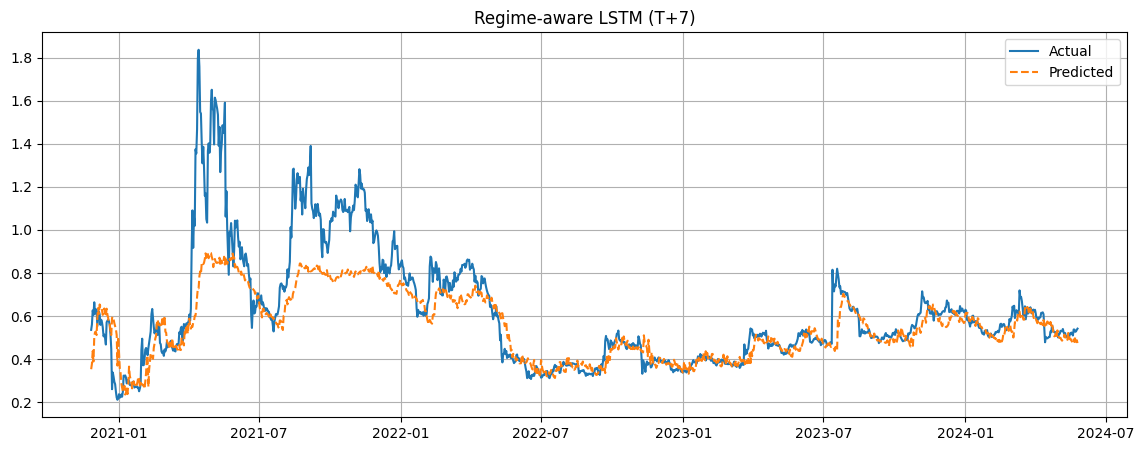

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===============================
# 1. LOAD DATA
# ===============================
df = pd.read_csv("data2.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)

EPS = 1e-8

# ===============================
# 2. FEATURE ENGINEERING
# ===============================
df['Volatility'] = df['High'] - df['Low']
df['VVR'] = df['Vol'] / (df['Volatility'] + EPS)

df['VWAP'] = ((df['High'] + df['Low'] + df['Price']) / 3 * df['Vol']).cumsum() / df['Vol'].cumsum()

for lag in [1,2,3,5,7]:
    df[f'Lag_{lag}'] = df['Price'].shift(lag)

df['Change'] = df['Price'].pct_change()
df['MA5'] = df['Price'].rolling(5).mean()
df['MA10'] = df['Price'].rolling(10).mean()

# ===== REGIME FEATURE =====
df['vol_z'] = (
    df['Volatility'] - df['Volatility'].rolling(30).mean()
) / (df['Volatility'].rolling(30).std() + EPS)

df['is_spike'] = (df['vol_z'] > 2).astype(int)

df = df.dropna().reset_index(drop=True)

# ===============================
# 3. SCALE
# ===============================
feature_cols = [c for c in df.columns if c not in ['Date', 'Price']]
X_raw = df[feature_cols].values
y_raw = df['Price'].values.reshape(-1,1)

sx = StandardScaler()
sy = StandardScaler()

X_scaled = sx.fit_transform(X_raw)
y_scaled = sy.fit_transform(y_raw).ravel()
dates = df['Date'].values

# ===============================
# 4. BUILD SEQUENCES
# ===============================
LOOKBACK = 30
HORIZON = 7

X_seq, y_seq, y_dates = [], [], []

for i in range(len(X_scaled) - LOOKBACK - HORIZON):
    X_seq.append(X_scaled[i:i+LOOKBACK])
    y_seq.append(y_scaled[i+LOOKBACK+HORIZON-1])
    y_dates.append(dates[i+LOOKBACK+HORIZON-1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_dates = np.array(y_dates)

# ===============================
# 5. SPLIT
# ===============================
split = int(len(X_seq) * 0.4)
X_tr, X_te = X_seq[:split], X_seq[split:]
y_tr, y_te = y_seq[:split], y_seq[split:]
date_te = y_dates[split:]

# ===============================
# 6. CUSTOM LSTM (GIỐNG BẠN)
# ===============================
def sigmoid(x): return 1/(1+np.exp(-x))
def dsigmoid(y): return y*(1-y)
def dtanh(y): return 1-y**2

class RegimeLSTM:
    def __init__(self, inp, hid):
        self.hid = hid
        self.Wf = np.random.randn(inp+hid, hid)*0.1
        self.Wi = np.random.randn(inp+hid, hid)*0.1
        self.Wc = np.random.randn(inp+hid, hid)*0.1
        self.Wo = np.random.randn(inp+hid, hid)*0.1
        self.Wy = np.random.randn(hid,1)*0.1
        self.b = np.zeros(hid)

    def forward(self, X):
        h = np.zeros(self.hid)
        c = np.zeros(self.hid)
        self.cache = []
        for x in X:
            z = np.concatenate([h,x])
            f = sigmoid(z@self.Wf)
            i = sigmoid(z@self.Wi)
            c_hat = np.tanh(z@self.Wc)
            o = sigmoid(z@self.Wo)
            c = f*c + i*c_hat
            h = o*np.tanh(c)
            self.cache.append((z,f,i,c_hat,o,c,h))
        y = h@self.Wy
        return y.item(), h

    def backward(self, y, yp, lr):
        dy = 2*(yp-y)
        h_last = self.cache[-1][6]
        self.Wy -= lr*np.outer(h_last,dy)

# ===============================
# 7. TRAIN
# ===============================
model = RegimeLSTM(X_tr.shape[2], 32)
LR = 0.001

for ep in range(60):
    loss = []
    for X,y in zip(X_tr,y_tr):
        yp,_ = model.forward(X)
        loss.append((yp-y)**2)
        model.backward(y,yp,LR)
    print(f"Epoch {ep+1} | Loss {np.mean(loss):.5f}")

# ===============================
# 8. TEST
# ===============================
pred = np.array([model.forward(X)[0] for X in X_te])

y_true = sy.inverse_transform(y_te.reshape(-1,1)).ravel()
y_pred = sy.inverse_transform(pred.reshape(-1,1)).ravel()

print("MSE:", mean_squared_error(y_true,y_pred))

plt.figure(figsize=(14,5))
plt.plot(date_te, y_true, label="Actual")
plt.plot(date_te, y_pred, "--", label="Predicted")
plt.title("Regime-aware LSTM (T+7)")
plt.legend()
plt.grid()
plt.show()
